In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install PyWavelets

In [ ]:
import pywt
def extract_wavelet_features(audio, wavelet='db4', level=5):
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    features = np.concatenate([np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs])
    return features

In [ ]:
def load_dataset(data_path):
    X = []
    y = []
    for speaker_dir in os.listdir(data_path):
        speaker_path = os.path.join(data_path, speaker_dir)
        if os.path.isdir(speaker_path) and speaker_dir != "background_noise":
            for file in os.listdir(speaker_path):
                file_path = os.path.join(speaker_path, file)
                if file_path.endswith('.wav'):
                    try:
                        audio, sr = librosa.load(file_path, sr=16000)
                        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                        mfccs_mean = np.mean(mfccs.T, axis=0)
                        X.append(mfccs_mean)
                        y.append(speaker_dir)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y)

def preprocess_data(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    return X, y_categorical, label_encoder

In [ ]:
#Вейвлетный слой
import tensorflow as tf
from tensorflow.keras.layers import Layer

class WaveletLayer(Layer):
    def __init__(self, wavelet='db4', level=5, **kwargs):
        super().__init__(**kwargs)
        self.wavelet = wavelet
        self.level = level

    def call(self, inputs):
        def pywt_transform(signal):
            signal = signal.numpy()
            coeffs = pywt.wavedec(signal, self.wavelet, level=self.level)
            features = np.concatenate([np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs])
            return features

        # Векторизованное преобразование для батча
        features = tf.py_function(
            lambda x: tf.stack([pywt_transform(s) for s in x]),
            [inputs],
            tf.float32
        )
        features.set_shape((None, (self.level + 1) * 2))  # (level+1)*2 признаков
        return features

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        WaveletLayer(wavelet='db4', level=5, input_shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(X_train, y_train, X_test, y_test, model):
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
    return model, history


def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

def predict_speaker(audio_path, model, label_encoder):
    audio, sr = librosa.load(audio_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    mfccs_mean = mfccs_mean.reshape(1, -1)
    predictions = model.predict(mfccs_mean)
    predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])[0]
    confidence = np.max(predictions)
    return predicted_class, confidence

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Speakers"
print("Loading dataset...")
X, y = load_dataset(DATASET_PATH)
print(f"Dataset loaded with {len(X)} samples.")

Loading dataset...


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1184
  warnings.warn(


Dataset loaded with 1142 samples.


In [ ]:
X, y, label_encoder = preprocess_data(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_test.shape[0]} samples")

Training set: 913 samples
Validation set: 229 samples


In [ ]:
model = build_model(input_shape=(X_train.shape[1],), num_classes=y_train.shape[1])
print("Training the model...")
model, history = train_model(X_train, y_train, X_test, y_test, model)
print("Evaluating the model...")
accuracy = evaluate_model(model, X_test, y_test)

Training the model...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1163 - loss: 37.5668 - val_accuracy: 0.3624 - val_loss: 3.6977
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2373 - loss: 9.7744 - val_accuracy: 0.2926 - val_loss: 1.7922
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2730 - loss: 3.7476 - val_accuracy: 0.1135 - val_loss: 2.1494
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3273 - loss: 2.2203 - val_accuracy: 0.3362 - val_loss: 2.0412
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3343 - loss: 2.0282 - val_accuracy: 0.3886 - val_loss: 1.8642
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3917 - loss: 1.8067 - val_accuracy: 0.4192 - val_loss: 1.7880
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3857 - loss: 1.7754 - val_accuracy: 0.4672 - val_loss: 1.6595
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4091 - loss: 1.6183 - val_accuracy: 0.4672 - val_loss: 1.5252
E

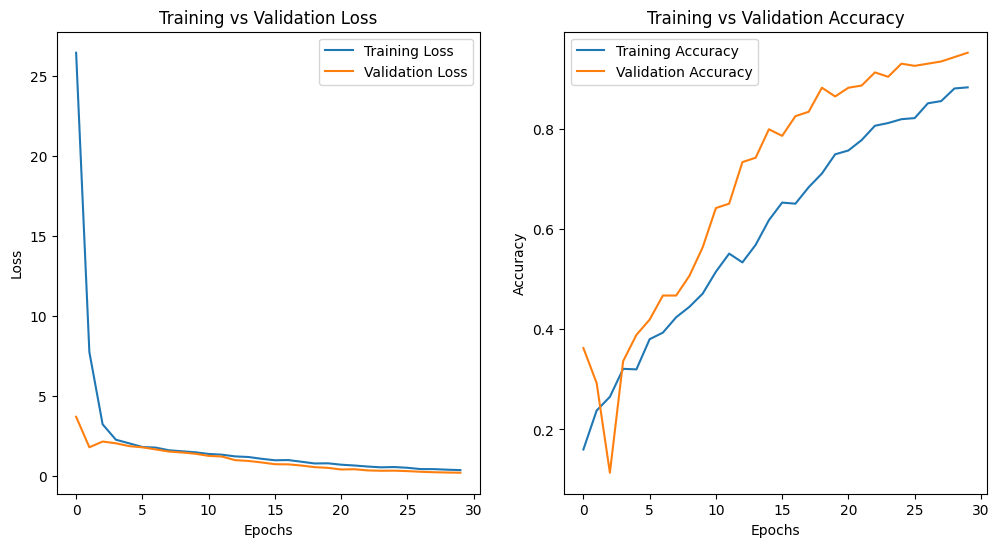

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_training_history(history):
    # График ошибки
    plt.figure(figsize=(12, 6))

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Точность
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
plot_training_history(history)

In [ ]:
model.save("/content/drive/MyDrive/speaker_identification_model.h5")
np.save("/content/drive/MyDrive/label_encoder_classes.npy", label_encoder.classes_)
print("Model and label encoder saved.")



Model and label encoder saved.


In [ ]:
TEST_AUDIO_PATH = "/content/drive/MyDrive/Speakers/Клыжук/77.wav"
predicted_speaker, confidence = predict_speaker(TEST_AUDIO_PATH, model, label_encoder)
if confidence:
    print(f"Predicted Speaker: {predicted_speaker}")
    print(f"Confidence: {confidence * 100:.2f}%")
else:
    print(f"Error: {predicted_speaker}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Speaker: Клыжук
Confidence: 84.39%


In [ ]:
def evaluate_on_test_set(X_test, y_test, label_encoder):
    print("Evaluating on the test set...")
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    predicted_speakers = label_encoder.inverse_transform(predicted_labels)
    true_speakers = label_encoder.inverse_transform(true_labels)
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Accuracy on test set: {accuracy * 100:.2f}%")
    print("\nSample Predictions:")
    for i in range(5):
        print(f"True Speaker: {true_speakers[i]} | Predicted Speaker: {predicted_speakers[i]}")

    return accuracy
test_accuracy = evaluate_on_test_set(X_test, y_test, label_encoder)

Evaluating on the test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy on test set: 95.20%

Sample Predictions:
True Speaker: Никита | Predicted Speaker: Никита
True Speaker: Федя | Predicted Speaker: Федя
True Speaker: Дирвук_Е.В | Predicted Speaker: Дирвук_Е.В
True Speaker: Артем | Predicted Speaker: Артем
True Speaker: Леша | Predicted Speaker: Клыжук


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


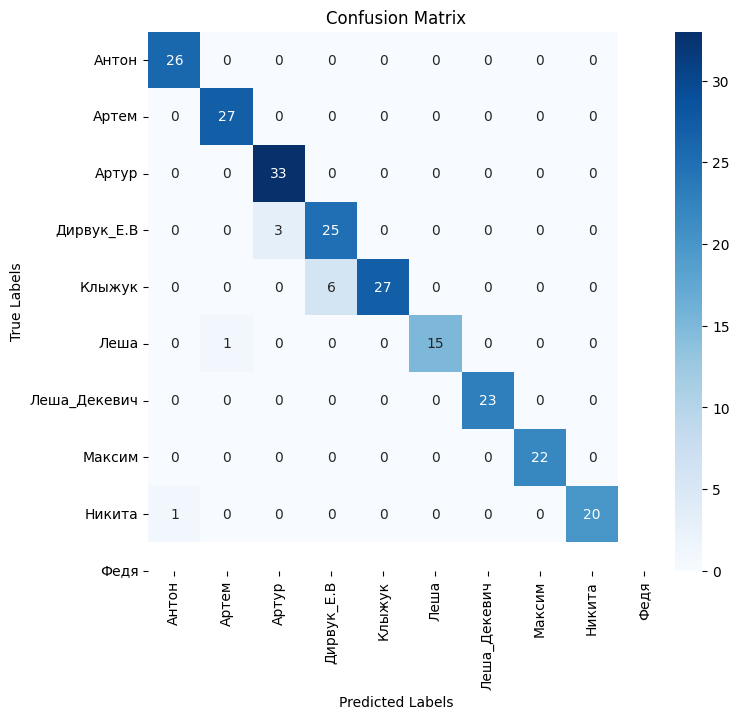

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate and plot the confusion matrix at the end of your script
def plot_confusion_matrix(model, X_test, y_test, label_encoder):
    # Get predictions
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Call the function at the end of your script
plot_confusion_matrix(model, X_test, y_test, label_encoder)
